Test GenerateRefData class on getting the contour of the reference image

In [43]:
from test_loss_define_v2 import GenerateRefData
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

#### Read and process the ground truth image

In [44]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

(480, 640)


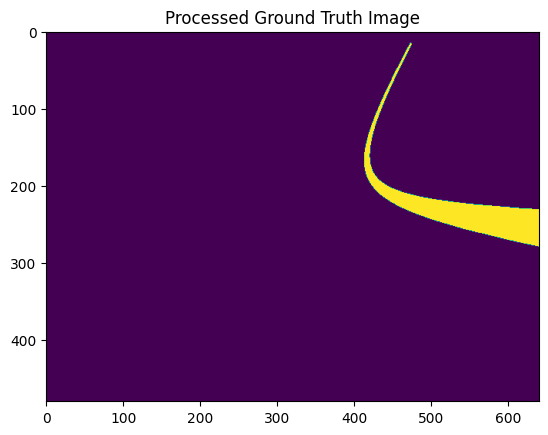

In [45]:
scripts_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2'
dataset_folder = "gt_dataset3"
gt_name = 'gt_6_0.0006_-0.0010_0.2_0.01'
case_naming = scripts_path + '/' + dataset_folder + '/' + gt_name
img_save_path = case_naming + '.png'
img_ref_binary = process_image(img_save_path)
plt.imshow(img_ref_binary)
plt.title('Processed Ground Truth Image')
print(img_ref_binary.shape)

#### Test the reference contour

In [46]:
image_ref = torch.from_numpy(img_ref_binary.astype(np.float32))
generate_ref_data = GenerateRefData(image_ref)
ref_catheter_contour = generate_ref_data.get_raw_contour().numpy()
print(ref_catheter_contour.shape)

(452, 2)


In [47]:
# downsample
num_points = 50
n = ref_catheter_contour.shape[0]
step = n // num_points
indices = np.arange(0, n, step)
ref_catheter_contour = ref_catheter_contour[indices]

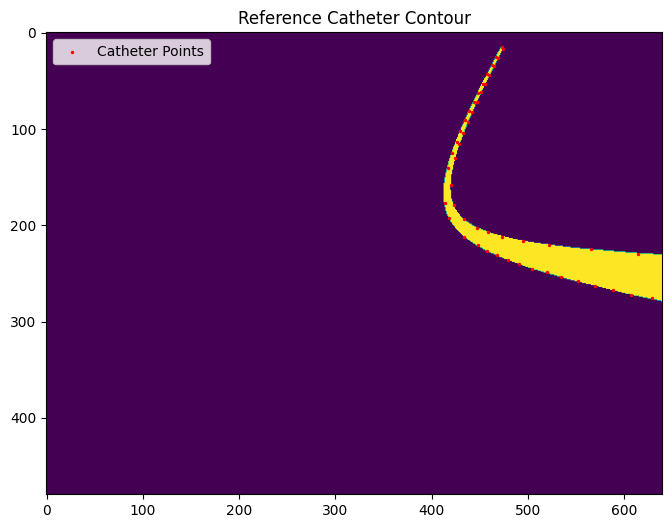

In [48]:
plt.figure(figsize=(8, 6))
plt.imshow(img_ref_binary)
plt.title('Reference Catheter Contour')

x = ref_catheter_contour[:, 0]
y = ref_catheter_contour[:, 1]
plt.scatter(x, y, c='red', s=2, label='Catheter Points')

plt.legend()
plt.show()

test on ContourChamferLoss

In [49]:
from test_recon_old import CatheterOptimizeModel

In [50]:
def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector

In [51]:
if torch.cuda.is_available():
    gpu_or_cpu = torch.device("cuda:0") 
    torch.cuda.set_device(gpu_or_cpu)
else:
    gpu_or_cpu = torch.device("cpu")

p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
para_init = np.array([0.034, -0.01, 0.536, 0.2, -0.37, 0.6],
                    dtype=np.float32)

gt_name = 'gt_6_0.0006_-0.0010_0.2_0.01'
case_naming = scripts_path + '/' + dataset_folder + '/' + gt_name
img_save_path = case_naming + '.png'
cc_specs_path = case_naming + '.npy'
# cc_specs_path = case_naming + '_gt.npy'
target_specs_path = None
viewpoint_mode = 1
transparent_mode = 0

'''
Create binary mask of catheter: 
    1) Grayscale the ref img, 
    2) threshold the grayscaled img, 
    3) Creates a binary image by replacing all 
        pixel values equal to 255 with 1 (leaves
        other pixel values unchanged)
'''

img_ref_binary = process_image(img_save_path)

para_gt_np = read_gt_params(cc_specs_path)
para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
end_effector_gt = para_gt[3:6]

###========================================================
### 3) SET UP AND RUN OPTIMIZATION MODEL
###========================================================
model = CatheterOptimizeModel(p_start, para_init, img_ref_binary, gpu_or_cpu, img_save_path)

In [52]:
model.build_bezier.getBezierCurveCylinder(model.p_start, model.para_init)
model.build_bezier.getCylinderMeshProjImg() # get build_bezier.bezier_proj_img
model.build_bezier.getBezierProjImg() # get build_bezier.bezier_proj_centerline_img
bezier_proj_img = model.build_bezier.bezier_proj_img.detach().numpy()
bezier_proj_centerline_img = model.build_bezier.bezier_proj_centerline_img.detach().numpy()
print("Shape of bezier_proj_img", bezier_proj_img.shape)
print("Shape of bezier_proj_centerline_img", bezier_proj_centerline_img.shape)
img_render_point_cloud = bezier_proj_img.reshape(bezier_proj_img.shape[0] * bezier_proj_img.shape[1], 2)
print("Shape of img_render_point_cloud", img_render_point_cloud.shape)

Shape of bezier_proj_img (30, 30, 2)
Shape of bezier_proj_centerline_img (30, 2)
Shape of img_render_point_cloud (900, 2)


In [53]:
print(bezier_proj_centerline_img)

[[ 1.76603642e+07  1.76624452e+06]
 [ 8.32898731e+02  2.58400217e+02]
 [ 5.99039895e+02  2.23859863e+02]
 [ 5.24580075e+02  2.04904765e+02]
 [ 4.90097972e+02  1.89575401e+02]
 [ 4.71715439e+02  1.75465604e+02]
 [ 4.61479085e+02  1.61760470e+02]
 [ 4.55985852e+02  1.48098776e+02]
 [ 4.53539588e+02  1.34288557e+02]
 [ 4.53203118e+02  1.20212230e+02]
 [ 4.54419211e+02  1.05788406e+02]
 [ 4.56838278e+02  9.09546516e+01]
 [ 4.60232256e+02  7.56586392e+01]
 [ 4.64448396e+02  5.98532637e+01]
 [ 4.69382687e+02  4.34939992e+01]
 [ 4.74964195e+02  2.65368199e+01]
 [ 4.81145197e+02  8.93702880e+00]
 [ 4.87894837e+02 -9.35149199e+00]
 [ 4.95195077e+02 -2.83773736e+01]
 [ 5.03037812e+02 -4.81921153e+01]
 [ 5.11423159e+02 -6.88508484e+01]
 [ 5.20358092e+02 -9.04129142e+01]
 [ 5.29855665e+02 -1.12942601e+02]
 [ 5.39934587e+02 -1.36509725e+02]
 [ 5.50618739e+02 -1.61190206e+02]
 [ 5.61937437e+02 -1.87067569e+02]
 [ 5.73925208e+02 -2.14233077e+02]
 [ 5.86622102e+02 -2.42787254e+02]
 [ 6.00074279e+02 -2

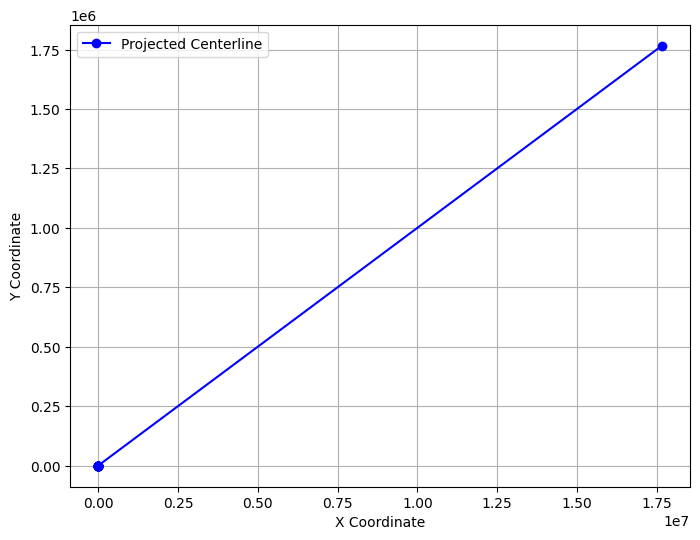

In [54]:
x = bezier_proj_centerline_img[:, 0]
y = bezier_proj_centerline_img[:, 1]

# 绘制这些坐标点
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Projected Centerline')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
# plt.title('Catheter Contour Plot')
plt.legend()
plt.grid(True)
plt.show()

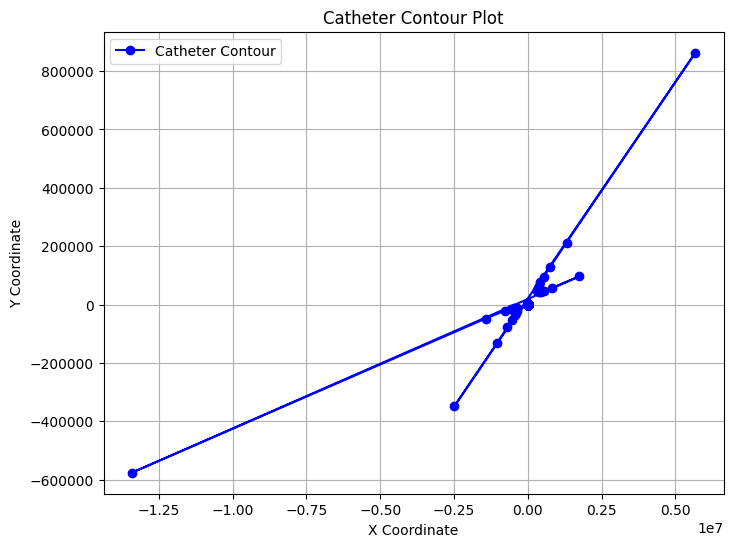

In [55]:
x = img_render_point_cloud[:, 0]
y = img_render_point_cloud[:, 1]

# 绘制这些坐标点
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Catheter Contour')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Catheter Contour Plot')
plt.legend()
plt.grid(True)
plt.show()

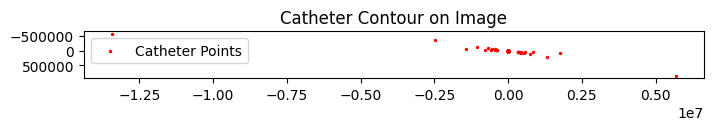

In [56]:
# 使用plt显示图片
plt.figure(figsize=(8, 6))
plt.imshow(img_ref_binary)
plt.title('Catheter Contour on Image')

# 在图片上绘制点
x = img_render_point_cloud[:, 0]
y = img_render_point_cloud[:, 1]
plt.scatter(x, y, c='red', s=2, label='Catheter Points')

# 显示图例
plt.legend()
plt.show()